<a href="https://colab.research.google.com/github/melvy13/ann-adult-income/blob/master/ANN_CompIntelAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Initial Setup**

---

In [1]:
!pip install ucimlrepo

# Tensorflow & scikit-learn already preinstalled in google colab

from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

**Data Loading**

---

In [2]:
def load_data():
  print("Loading dataset via ucimlrepo...")

  adult = fetch_ucirepo(id=2) # ID 2 for Adult dataset
  X_raw = adult.data.features
  y_raw = adult.data.targets
  df = pd.concat([X_raw, y_raw], axis=1)

  print("\nUCI Adult Dataset (ID 2) loaded")

  return df

df = load_data()

Loading dataset via ucimlrepo...

UCI Adult Dataset (ID 2) loaded


**Initial Inspection**

---




   BASIC DATASET INFORMATION

Dataset Shape: 48842 rows × 15 columns

Column Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
Memory Usage:
26.44817352294

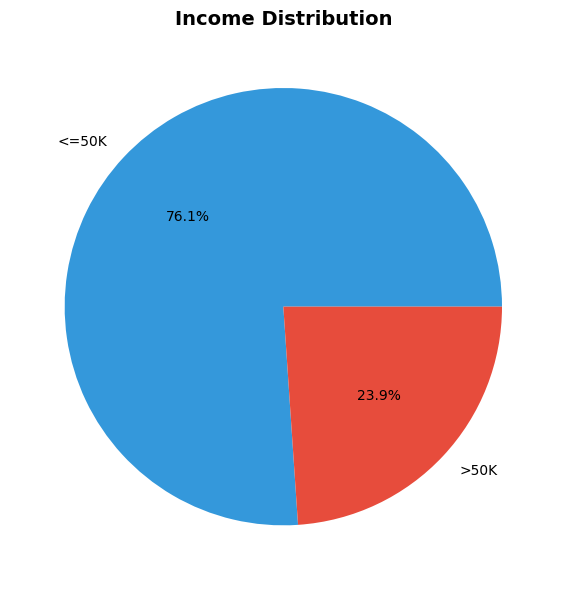


   KEY FEATURES vs INCOME ANALYSIS


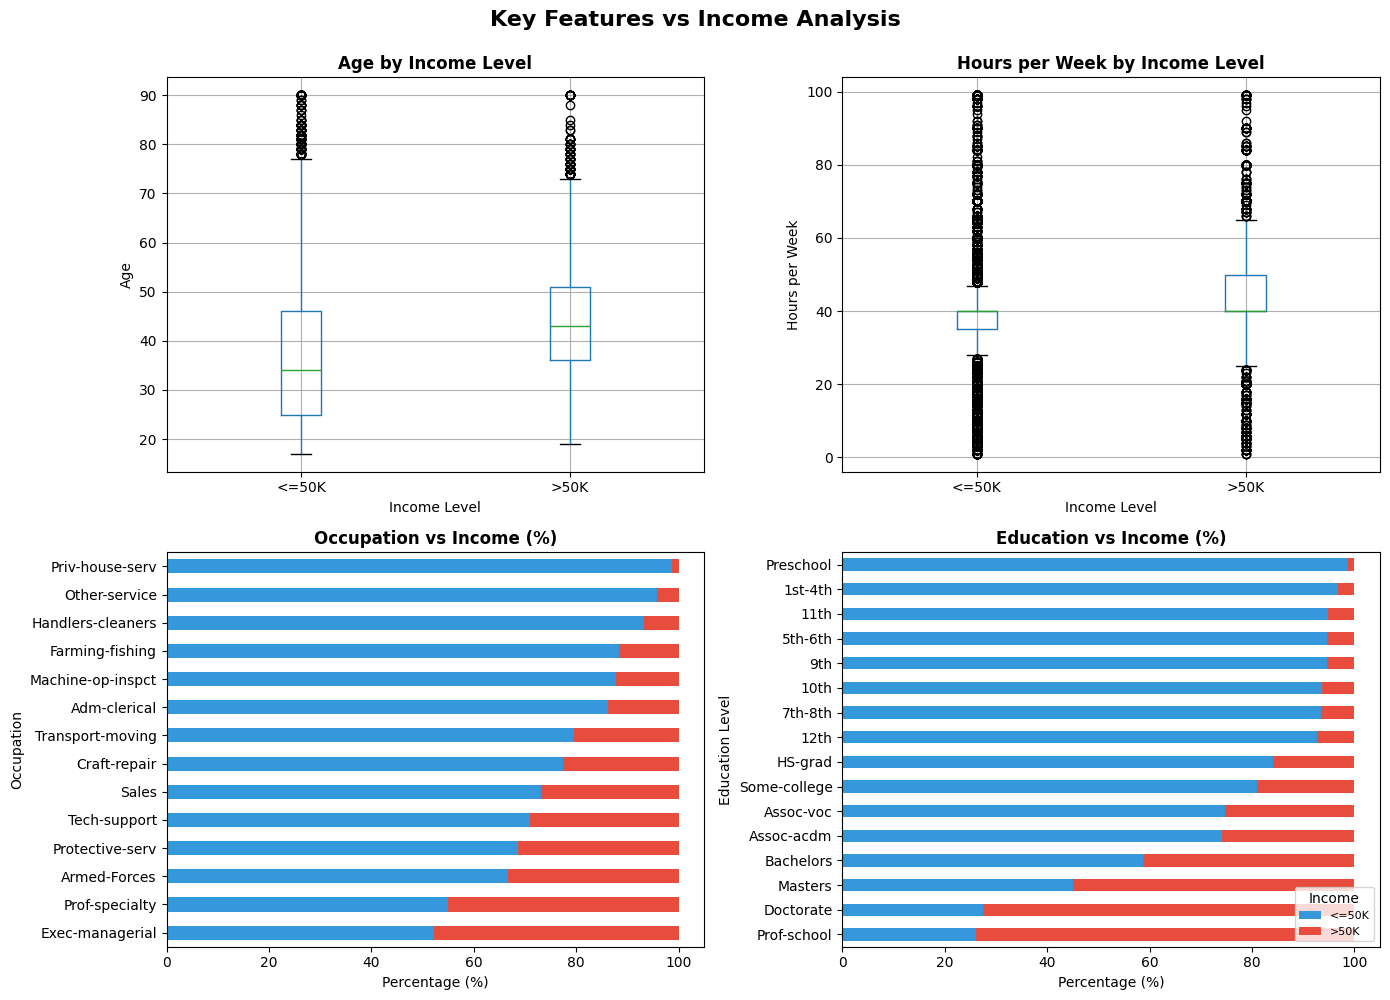


   NATIVE-COUNTRY DISTRIBUTION

Native-Country Distribution (Top 15):
native-country
United-States         43832
Mexico                  951
Philippines             295
Germany                 206
Puerto-Rico             184
Canada                  182
El-Salvador             155
India                   151
Cuba                    138
England                 127
China                   122
South                   115
Jamaica                 106
Italy                   105
Dominican-Republic      103
Name: count, dtype: int64

Total unique countries: 42
United-States count: 43832 (89.7%)
Other countries combined: 5010 (10.3%)

   CORRELATION MATRIX


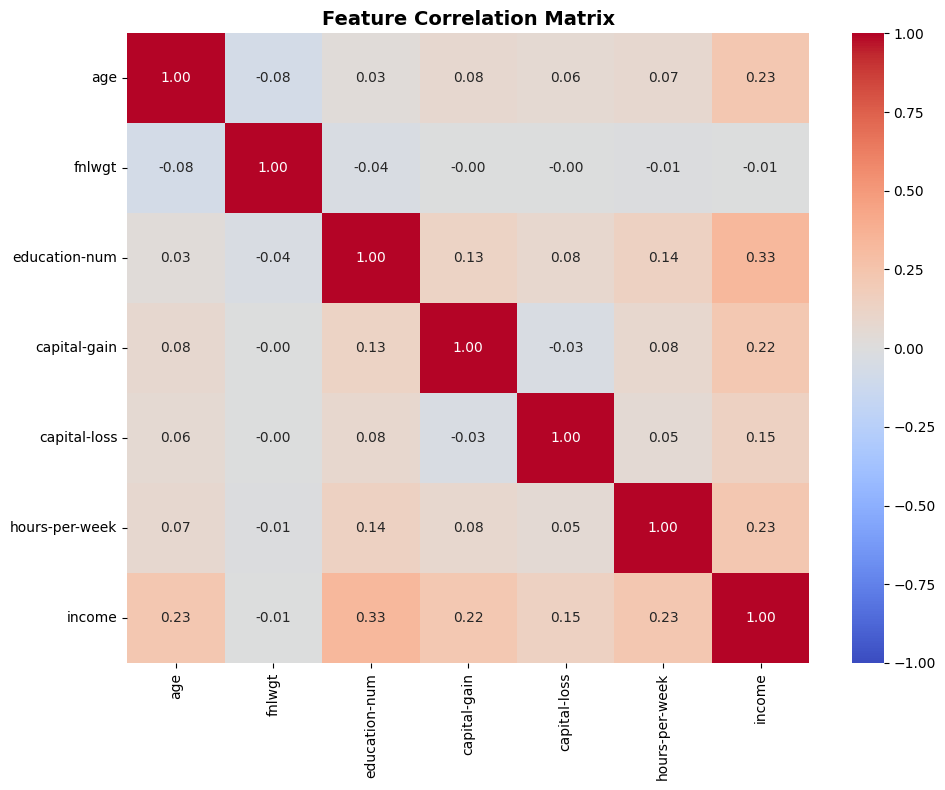

In [3]:
def inspect_raw_data(df):
  print("\n" + "="*31)
  print("   BASIC DATASET INFORMATION")
  print("="*31)

  print(f"\nDataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")

  # List of variables
  print("\nColumn Summary:")
  df.info(memory_usage=False)

  # Memory needed to process the dataset
  print(f"\nMemory Usage:")
  print(df.memory_usage(deep=True).sum() / 1024**2, "MB")

  # Display first 5 rows
  print(f"\nFirst 5 rows:")
  print(df.head(5))

  # For numerical variables
  print(f"\nNumerical Statistics:")
  print(df.describe().round(2).T)

  # For categorical variables
  print("\nCategorical Statistics:")
  print(df.select_dtypes(include=['object']).describe().T)

  print(f"\nDuplicates:")
  print(f"Dataset contains {df.duplicated().sum()} duplicate rows")

  print("\n" + "="*29)
  print("   MISSING VALUES ANALYSIS")
  print("="*29)

  # Check for NaN / Null
  print("\nMissing values (NaN / Null):")
  missing = df.isnull().sum()
  if missing.sum() > 0:
    print(missing[missing > 0])

    missing_rows_count = df.isnull().any(axis=1).sum()
    print(f"\nRows with missing (NaN/Null) values: {missing_rows_count}")
  else:
    print("No missing values found")

  # Check for '?'
  print("\nUnknown values (?):")
  unknown = (df == '?').sum()
  if unknown.sum() > 0:
    print(unknown[unknown > 0])

    unknown_rows_count = (df == '?').any(axis=1).sum()
    print(f"\nRows with unknown (?) values: {unknown_rows_count}")
  else:
    print("No unknown values found")

  print("\n" + "="*43)
  print("   TARGET VARIABLE DISTRIBUTION (Income)")
  print("="*43)

  # Number of unique values for 'income'
  unique_targets = df['income'].unique()
  print(f"\nUnique targets: {unique_targets}")

  # Since there is 4 unique values for income (supposedly 2) -
  #   ['<=50K' '>50K' '<=50K.' '>50K.'] ;
  #   combine '<=50K' with '<=50K.' & '50K' with '>50K.' for plotting purposes
  df_temp = df.copy()
  df_temp['income'] = df_temp['income'].str.replace('.', '', regex=False)

  print(f"\nIncome Distribution:")
  print(df_temp['income'].value_counts())
  print()

  # Plot pie chart for income distribution
  plt.figure(figsize=(8, 6))
  df_temp['income'].value_counts().plot(kind='pie', autopct='%1.1f%%',
                                        colors=['#3498db', '#e74c3c'])
  plt.title('Income Distribution', fontsize=14, fontweight='bold')
  plt.ylabel('')
  plt.tight_layout()
  plt.show()

  print("\n" + "="*37)
  print("   KEY FEATURES vs INCOME ANALYSIS")
  print("="*37)

  fig, axes = plt.subplots(2, 2, figsize=(14, 10))

  # Age vs Income
  df_temp.boxplot(column='age', by='income', ax=axes[0, 0])
  axes[0, 0].set_title('Age by Income Level', fontsize=12, fontweight='bold')
  axes[0, 0].set_xlabel('Income Level', fontsize=10)
  axes[0, 0].set_ylabel('Age', fontsize=10)
  plt.sca(axes[0, 0])
  plt.xticks(rotation=0)

  # Hours per week vs Income
  df_temp.boxplot(column='hours-per-week', by='income', ax=axes[0, 1])
  axes[0, 1].set_title('Hours per Week by Income Level', fontsize=12, fontweight='bold')
  axes[0, 1].set_xlabel('Income Level', fontsize=10)
  axes[0, 1].set_ylabel('Hours per Week', fontsize=10)
  plt.sca(axes[0, 1])
  plt.xticks(rotation=0)

  # Occupation vs Income
  df_occupation = df_temp[df_temp['occupation'] != '?'].copy()
  occupation_income = pd.crosstab(df_occupation['occupation'],
                                     df_occupation['income'],
                                     normalize='index') * 100
  occupation_income = occupation_income.sort_values(by='>50K', ascending=False)
  occupation_income.plot(kind='barh', stacked=True, ax=axes[1, 0],
                          color=['#3498db', '#e74c3c'], legend=False)
  axes[1, 0].set_title('Occupation vs Income (%)', fontsize=12, fontweight='bold')
  axes[1, 0].set_xlabel('Percentage (%)', fontsize=10)
  axes[1, 0].set_ylabel('Occupation', fontsize=10)

  # Education vs Income
  education_income = pd.crosstab(df_temp['education'],
                                    df_temp['income'],
                                    normalize='index') * 100
  education_income = education_income.sort_values(by='>50K', ascending=False)
  education_income.plot(kind='barh', stacked=True, ax=axes[1, 1],
                         color=['#3498db', '#e74c3c'])
  axes[1, 1].set_title('Education vs Income (%)', fontsize=12, fontweight='bold')
  axes[1, 1].set_xlabel('Percentage (%)', fontsize=10)
  axes[1, 1].set_ylabel('Education Level', fontsize=10)
  axes[1, 1].legend(title='Income', loc='lower right', fontsize=8)

  plt.suptitle('Key Features vs Income Analysis', fontsize=16, fontweight='bold', y=0.995)
  plt.tight_layout()
  plt.show()

  # Native-country distribution
  print("\n" + "="*33)
  print("   NATIVE-COUNTRY DISTRIBUTION")
  print("="*33)

  print("\nNative-Country Distribution (Top 15):")
  df_country = df_temp[df_temp['native-country'] != '?'].copy()
  country_counts = df_country['native-country'].value_counts()
  print(country_counts.head(15))

  total_countries = df['native-country'].nunique()
  us_count = (df['native-country'] == 'United-States').sum()
  us_percentage = (us_count / len(df)) * 100

  print(f"\nTotal unique countries: {total_countries}")
  print(f"United-States count: {us_count} ({us_percentage:.1f}%)")
  print(f"Other countries combined: {len(df) - us_count} ({100 - us_percentage:.1f}%)")

  # Correlation Matrix
  print("\n" + "="*24)
  print("   CORRELATION MATRIX")
  print("="*24)

  df_corr = df_temp.copy()

  # Encode target income
  df_corr['income'] = df_corr['income'].apply(lambda x: 1 if '>50K' in x else 0)

  numeric_cols = df_corr.select_dtypes(include=['int64', 'float64']).columns

  plt.figure(figsize=(10, 8))

  # Compute correlation
  corr = df_corr[numeric_cols].corr()

  # Plot heatmap
  sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
  plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
  plt.tight_layout()
  plt.show()

inspect_raw_data(df)

**Data Cleaning**

---

In [4]:
def clean_data(df):
  print("\nCleaning dataset...")

  df_clean = df.copy()

  # Strip any whitespace from all string (object) columns
  cat_cols = df_clean.select_dtypes(['object']).columns
  df_clean[cat_cols] = df_clean[cat_cols].apply(lambda x: x.str.strip())
  print("\nStripped whitespaces")

  # Convert '?' to NaN then drop all missing data
  df_clean.replace('?', np.nan, inplace=True)
  missing_rows_count = df_clean.isnull().any(axis=1).sum()
  df_clean.dropna(inplace=True)
  print(f"Removed {missing_rows_count} rows with missing values")

  # Drop duplicates rows
  duplicate_count = df_clean.duplicated().sum()
  df_clean.drop_duplicates(inplace=True)
  print(f"Removed {duplicate_count} duplicate rows")

  # Drop irrelevant or redundant columns
  #  - fnlwgt: no predictive value
  #  - education: redundant with education-num
  df_clean.drop(columns=['fnlwgt', 'education'], inplace=True)
  print("Dropped 'fnlwgt' & 'education' columns")

  # Standardize target variable (income) to 2 unique values: <=50K & >50K
  # Original contains: <=50K, <=50K., >50K, >50K.
  df_clean['income'] = df_clean['income'].str.replace('.', '', regex=False)
  print('Standardized target variable (income)')

  # Group native-country into 'United-States' vs 'Other'
  #   to help reduces high cardinality & simplifies modeling
  df_clean['native-country'] = df_clean['native-country'].apply(
      lambda x: 'United-States' if x == 'United-States' else 'Other'
  )
  print("Grouped non-US countries to a single category: 'Other'")

  # Reset index
  df_clean.reset_index(inplace=True, drop=True)

  # Preview
  print(f"\nFinal dataset shape: {df_clean.shape[0]} rows × {df_clean.shape[1]} columns")

  print("\nFirst 5 rows of cleaned dataset:")
  print(df_clean.head(5))

  print("\nColumn Summary:")
  df_clean.info(memory_usage=False)

  print(f"\nMemory Usage:")
  print(df_clean.memory_usage(deep=True).sum() / 1024**2, "MB")

  print("\nExample categorical distributions:")
  for col in ['workclass', 'marital-status', 'occupation', 'income']:
      print(f"\nValue counts for '{col}':")
      print(df_clean[col].value_counts())

  print("\nDataset cleaned")

  return df_clean

df_clean = clean_data(df)


Cleaning dataset...

Stripped whitespaces
Removed 3620 rows with missing values
Removed 28 duplicate rows
Dropped 'fnlwgt' & 'education' columns
Standardized target variable (income)
Grouped non-US countries to a single category: 'Other'

Final dataset shape: 45194 rows × 13 columns

First 5 rows of cleaned dataset:
   age         workclass  education-num      marital-status  \
0   39         State-gov             13       Never-married   
1   50  Self-emp-not-inc             13  Married-civ-spouse   
2   38           Private              9            Divorced   
3   53           Private              7  Married-civ-spouse   
4   28           Private             13  Married-civ-spouse   

          occupation   relationship   race     sex  capital-gain  \
0       Adm-clerical  Not-in-family  White    Male          2174   
1    Exec-managerial        Husband  White    Male             0   
2  Handlers-cleaners  Not-in-family  White    Male             0   
3  Handlers-cleaners        Hu

**Data Preprocessing**

---

In [5]:
def preprocess_data(df):
  print("\nPreprocessing dataset...")

  df = df.copy()

  # Encode Target (Income) - '<=50K': 0 ; '>50K': 1
  print("\nEncoding target (income) as 0/1...")
  le = LabelEncoder()
  y = le.fit_transform(df['income'])
  print(f"  Target Mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

  # One-Hot Encoding (Convert categorical features to binary format)
  print("\nOne-Hot Encoding categorical features...")
  X = df.drop(columns=['income'])
  X_encoded = pd.get_dummies(X, drop_first=True, dtype=int)

  print(f"   Features before encoding: {X.shape[1]}")
  print(f"   Features after encoding: {X_encoded.shape[1]}")

  # Split Data (Train 70% / Val 15% / Test 15%)
  # First Split: 70% Train, 30% Temp
  print("\nSplitting data...")
  X_train, X_temp, y_train, y_temp = train_test_split(
      X_encoded, y, test_size=0.30, random_state=42, stratify=y
  )

  # Second Split: Split 30% Temp into half (15% Val, 15% Test)
  X_val, X_test, y_val, y_test = train_test_split(
      X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
  )
  print("  Dataset split in 70:15:15 ratio")

  X_train = X_train.copy()
  X_val = X_val.copy()
  X_test = X_test.copy()

  # Scaling (ONLY NUMERICAL COLUMNS)
  scaler = StandardScaler()

  # Define the columns that are actually numbers
  # (to exclude new 0/1 columns from one-hot encoding)
  num_cols = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

  # Fit scaler on training data only (prevent data leakage)
  print(f"\nScaling numerical columns: {num_cols}")
  scaler.fit(X_train[num_cols])

  # Transform all splits
  X_train[num_cols] = scaler.transform(X_train[num_cols])
  X_val[num_cols]   = scaler.transform(X_val[num_cols])
  X_test[num_cols]  = scaler.transform(X_test[num_cols])

  print("\nDataset preprocessed & split successfully")

  return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = preprocess_data(df_clean)


Preprocessing dataset...

Encoding target (income) as 0/1...
  Target Mapping: {'<=50K': np.int64(0), '>50K': np.int64(1)}

One-Hot Encoding categorical features...
   Features before encoding: 12
   Features after encoding: 41

Splitting data...
  Dataset split in 70:15:15 ratio

Scaling numerical columns: ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

Dataset preprocessed & split successfully


**Constructing ANN Model**

---

In [6]:
def construct_model(input_dim):
  print("\nConstructing ANN Model...")

  model = Sequential([
      # Input layer
      Input(shape=(input_dim,)),

      Dense(256, activation='relu'), Dropout(0.3),

      # First hidden layer
      Dense(128, activation='relu'), Dropout(0.3),

      # Second hidden layer
      Dense(64, activation='relu'), Dropout(0.2),

      # Third hidden layer
      Dense(32, activation='relu'), Dropout(0.2),

      # Output layer
      Dense(1, activation='sigmoid')
  ])

  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='binary_crossentropy',
      metrics=['accuracy', 'AUC']
  )

  # Print architecture decisions
  print("\nArchitecture Design:")
  print(f"   Input Features: {input_dim}")
  print("   Hidden Layers: 4 (256 → 128 → 64 → 32)")
  print("   Activation: ReLU")
  print("   Regularization: Dropout (0.3, 0.3, 0.2, 0.2)")
  print("   Output: 1 neuron (Sigmoid for binary classification)")

  print("\nModel architecture:")
  model.summary()

  print("\nTraining Configuration:")
  print("   Optimizer: Adam (learning rate=0.001)")
  print("   Loss: Binary Crossentropy")
  print("   Metrics: Accuracy, Area Under Curve")

  print("\nModel constructed")
  return model

input_dim = X_train.shape[1]
model = construct_model(input_dim)


Constructing ANN Model...

Architecture Design:
   Input Features: 41
   Hidden Layers: 4 (256 → 128 → 64 → 32)
   Activation: ReLU
   Regularization: Dropout (0.3, 0.3, 0.2, 0.2)
   Output: 1 neuron (Sigmoid for binary classification)

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        10,752 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,017 (211.00 KB)

 Trainable params: 54,017 (211.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Configuration:
   Optimizer: Adam (learning rate=0.001)
   Loss: Binary Crossentropy
   Metrics: Accuracy, Area Under Curve

Model constructed


**Training ANN Model**

---

In [7]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50):
  print("\nTraining model...")

  ## Uncomment below code block & class weight argument in model.fit() to include class weights for better recalls for >50K

  # Calculate class weights
  # class_weights = compute_class_weight(
  #     'balanced',
  #     classes=np.unique(y_train),
  #     y=y_train
  # )
  # class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
  # print(f"Class weights: {class_weight_dict}")

  callbacks = [
      EarlyStopping(
          monitor='val_loss',
          patience=10,
          restore_best_weights=True
      ),
      ReduceLROnPlateau(
          monitor='val_loss',
          factor=0.5,
          patience=5,
          min_lr=1e-6
      )
  ]

  history = model.fit(
      X_train, y_train,
      # class_weight=class_weight_dict,
      validation_data=(X_val, y_val),
      epochs=epochs,
      batch_size=32,
      callbacks=callbacks,
      verbose=1
  )

  print("\nModel trained")
  return model, history

model, history = train_model(model, X_train, y_train, X_val, y_val, 50)


Training model...
Epoch 1/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - AUC: 0.8604 - accuracy: 0.8248 - loss: 0.3786 - val_AUC: 0.9099 - val_accuracy: 0.8473 - val_loss: 0.3186 - learning_rate: 0.0010
Epoch 2/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9003 - accuracy: 0.8482 - loss: 0.3317 - val_AUC: 0.9100 - val_accuracy: 0.8472 - val_loss: 0.3188 - learning_rate: 0.0010
Epoch 3/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.9045 - accuracy: 0.8529 - loss: 0.3256 - val_AUC: 0.9109 - val_accuracy: 0.8458 - val_loss: 0.3198 - learning_rate: 0.0010
Epoch 4/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9104 - accuracy: 0.8562 - loss: 0.3153 - val_AUC: 0.9120 - val_accuracy: 0.8482 - val_loss: 0.3174 - learning_rate: 0.0010
Epoch 5/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - AUC: 0.9112 - accuracy: 0.8534 - loss: 0.3223 - val_AUC: 0.9110 - val_accuracy: 0.8485 - val_loss: 0.3166 - learning_rate: 0.0010
Epoch 6/50
989/989 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - AUC: 0.

**Visualization and Evaluation**

---


Generating predictions...
212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

   EVALUATION REPORT
Test Loss:     0.3141
Test Accuracy: 0.8563
Test AUC:      0.9125

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.90      0.92      0.91      5099
        >50K       0.73      0.68      0.70      1681

    accuracy                           0.86      6780
   macro avg       0.81      0.80      0.80      6780
weighted avg       0.85      0.86      0.85      6780



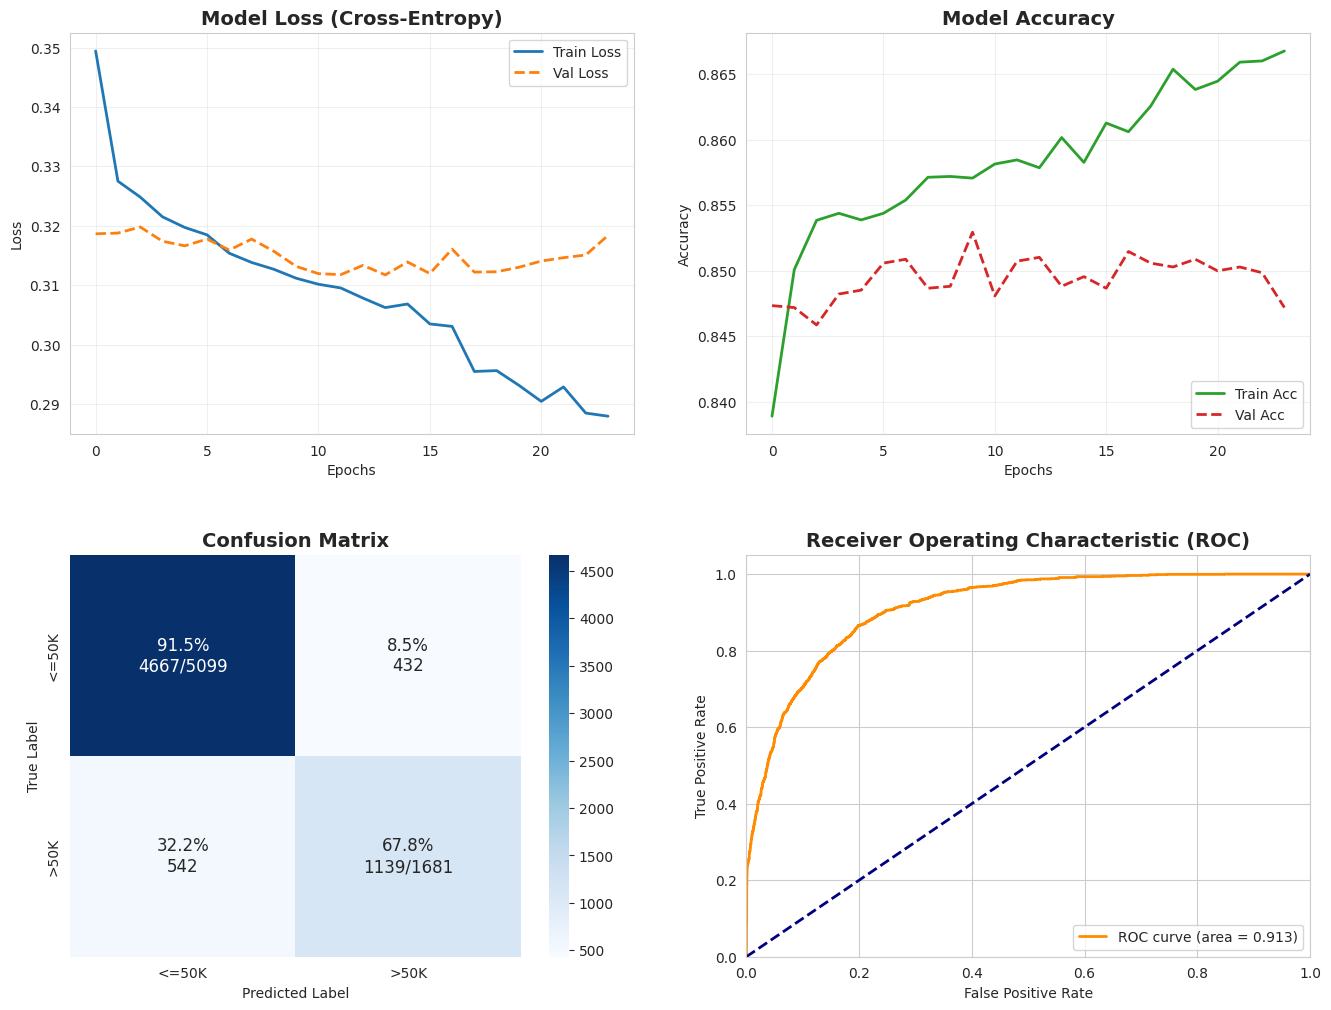

In [8]:
def visualize_and_evaluate(model, history, X_test, y_test):
  # Generate predictions
  print("\nGenerating predictions...")
  y_pred_prob = model.predict(X_test)
  y_pred = (y_pred_prob > 0.5).astype(int)

  print("\n" + "="*23)
  print("   EVALUATION REPORT")
  print("="*23)

  # Evaluation [loss, accuracy, auc]
  results = model.evaluate(X_test, y_test, verbose=0)
  print(f"Test Loss:     {results[0]:.4f}")
  print(f"Test Accuracy: {results[1]:.4f}")
  print(f"Test AUC:      {results[2]:.4f}")

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

  # Visualization Grid (2x2)
  sns.set_style("whitegrid")
  fig, axes = plt.subplots(2, 2, figsize=(16, 12))
  plt.subplots_adjust(hspace=0.3)

  # Plot A: Loss Curve (Training vs Validation)
  axes[0,0].plot(history.history['loss'], label='Train Loss', color='#1f77b4', linewidth=2)
  axes[0,0].plot(history.history['val_loss'], label='Val Loss', color='#ff7f0e', linewidth=2, linestyle='--')
  axes[0,0].set_title('Model Loss (Cross-Entropy)', fontsize=14, fontweight='bold')
  axes[0,0].set_xlabel('Epochs')
  axes[0,0].set_ylabel('Loss')
  axes[0,0].legend()
  axes[0,0].grid(True, alpha=0.3)

  # Plot B: Accuracy Curve
  axes[0,1].plot(history.history['accuracy'], label='Train Acc', color='#2ca02c', linewidth=2)
  axes[0,1].plot(history.history['val_accuracy'], label='Val Acc', color='#d62728', linewidth=2, linestyle='--')
  axes[0,1].set_title('Model Accuracy', fontsize=14, fontweight='bold')
  axes[0,1].set_xlabel('Epochs')
  axes[0,1].set_ylabel('Accuracy')
  axes[0,1].legend(loc='lower right')
  axes[0,1].grid(True, alpha=0.3)

  # Plot C: Confusion Matrix Heatmap
  cm = confusion_matrix(y_test, y_pred)

  cm_sum = np.sum(cm, axis=1, keepdims=True)
  cm_perc = cm / cm_sum.astype(float) * 100
  annot = np.empty_like(cm).astype(str)
  nrows, ncols = cm.shape

  for i in range(nrows):
    for j in range(ncols):
      c = cm[i, j]
      p = cm_perc[i, j]

      if i == j:
        s = cm_sum[i]
        annot[i, j] = '%.1f%%\n%d/%d' % (p.item(), c.item(), s.item())
      elif c == 0:
        annot[i, j] = ''
      else:
        annot[i, j] = '%.1f%%\n%d' % (p.item(), c.item())

  sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=axes[1,0],
              xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'],
              annot_kws={"size": 12})
  axes[1,0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
  axes[1,0].set_ylabel('True Label')
  axes[1,0].set_xlabel('Predicted Label')

  # Plot D: ROC Curve
  fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
  roc_auc = auc(fpr, tpr)

  axes[1,1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
  axes[1,1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  axes[1,1].set_xlim([0.0, 1.0])
  axes[1,1].set_ylim([0.0, 1.05])
  axes[1,1].set_xlabel('False Positive Rate')
  axes[1,1].set_ylabel('True Positive Rate')
  axes[1,1].set_title('Receiver Operating Characteristic (ROC)', fontsize=14, fontweight='bold')
  axes[1,1].legend(loc="lower right")

  plt.show()

visualize_and_evaluate(model, history, X_test, y_test)